# Notebook to view Basic Training Data from ECMWF

In [1]:
from AI_WQ_package import retrieve_training_data
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd

%load_ext autoreload
%autoreload 2

- year (int): The year of requested data, i.e. 2000. The year must be between 1979 and 2024 inclusive.

- variable (str): The requested variable. Options are:

    - 'tas': Near-surface temperature

    - 'mslp': Mean sea level pressure

    - 'pr': Precipitation

- password (str): The forecast submission password provided in your registration email.

In [2]:
tas_list = []
for i in range(2019,2024):
    tas_list.append(retrieve_training_data.retrieve_annual_training_data(i,'mslp','NegF8LfwK',None))


File '/training_data/mslp_sevenday_WEEKLYMEAN_2019.nc' has been downloaded to successfully to 'mslp_sevenday_WEEKLYMEAN_2019.nc'.
File '/training_data/mslp_sevenday_WEEKLYMEAN_2020.nc' has been downloaded to successfully to 'mslp_sevenday_WEEKLYMEAN_2020.nc'.
File '/training_data/mslp_sevenday_WEEKLYMEAN_2021.nc' has been downloaded to successfully to 'mslp_sevenday_WEEKLYMEAN_2021.nc'.
File '/training_data/mslp_sevenday_WEEKLYMEAN_2022.nc' has been downloaded to successfully to 'mslp_sevenday_WEEKLYMEAN_2022.nc'.
File '/training_data/mslp_sevenday_WEEKLYMEAN_2023.nc' has been downloaded to successfully to 'mslp_sevenday_WEEKLYMEAN_2023.nc'.


In [17]:
tas_list

[<xarray.Dataset> Size: 42MB
 Dimensions:    (longitude: 240, latitude: 121, time: 365)
 Coordinates:
   * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
   * latitude   (latitude) float64 968B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
   * time       (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
 Data variables:
     mslp       (time, latitude, longitude) float32 42MB ...,
 <xarray.Dataset> Size: 43MB
 Dimensions:    (longitude: 240, latitude: 121, time: 366)
 Coordinates:
   * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
   * latitude   (latitude) float64 968B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
   * time       (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
 Data variables:
     mslp       (time, latitude, longitude) float32 43MB ...,
 <xarray.Dataset> Size: 42MB
 Dimensions:    (longitude: 240, latitude: 121, time: 365)
 Coordinates:
   * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ..

# Playground

## TIme series for near surface temperature (2019-2023) for a single grid point

In [20]:
tas_list[0].variables['mslp'][:]

<xarray.Variable (time: 365, latitude: 121, longitude: 240)> Size: 42MB
[10599600 values with dtype=float32]
Attributes:
    code:          151
    table:         128
    cell_methods:  time: mean

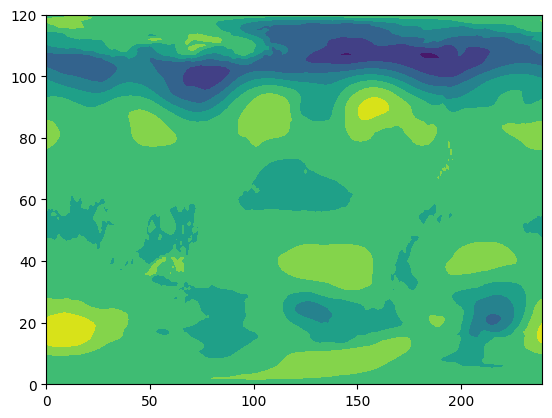

In [21]:
plt.contourf(tas_list[0].variables['mslp'][:][100,:,:])

Text(0.5, 1.0, 'Time series of near surface temperature (2019-2023)')

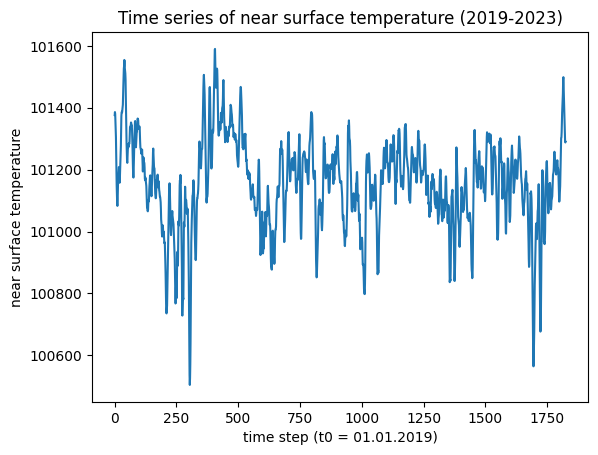

In [22]:
dates = pd.DatetimeIndex((tas_list[0].variables['time']))
months = np.array(dates.month - 1)
tas = np.array(tas_list[0].variables['mslp'][:][:,50,100])
for i in range(1,len(tas_list)):
    tas = np.append(tas,tas_list[i].variables['mslp'][:][:,50,100])
    dates = pd.DatetimeIndex((tas_list[0].variables['time']))
    months = np.append(months,np.array(dates.month)- 1)
months = np.append(months,np.array(0))
plt.plot(tas)
plt.xlabel('time step (t0 = 01.01.2019)')
plt.ylabel('near surface temperature')
plt.title('Time series of near surface temperature (2019-2023)')


In [23]:
months

array([ 0,  0,  0, ..., 11, 11,  0], shape=(1826,))

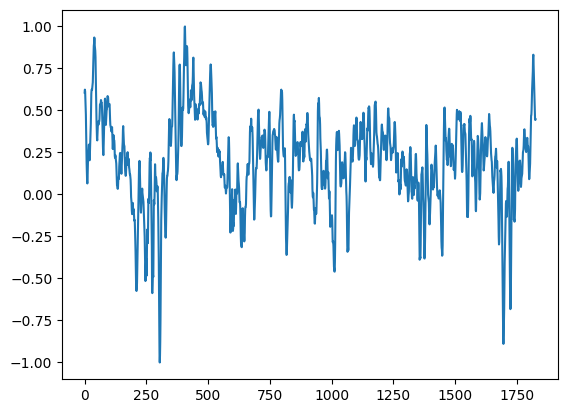

In [ ]:
def my_norm(a):
    
    ratio = 2/(np.max(a)-np.min(a)) 
    #as you want your data to be between -1 and 1, everything should be scaled to 2, 
    #if your desired min and max are other values, replace 2 with your_max - your_min
    shift = (np.max(a)+np.min(a))/2 
    #now you need to shift the center to the middle, this is not the average of the values.
    return (a - shift)*ratio

data = my_norm(tas)
plt.plot(data)

In [25]:
tas

array([101376.52 , 101386.055, 101380.29 , ..., 101289.76 , 101287.87 ,
       101290.44 ], shape=(1826,), dtype=float32)

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from src.model import simpleTransformerModel, TransformerModel
from src.prepare_data import TimeSeriesDataset, TimeSeriesDatasetWithCat
from src.train import train, evaluate
from src.plot import plot_predictions

# Simple Model

## Prepare Data

In [27]:
# Prepare dataset
seq_len = 24*7  # Length of sequence window for prediction
X = data[:-24*1].reshape(-1, 1) 
y = data[24*1:].reshape(-1, 1)  

# Split data
train_size = int(len(X) * 0.8)  # Use 80% of data for training
train_X, train_y = X[:train_size], y[:train_size]  # Training sets
test_X, test_y = X[train_size:], y[train_size:]   # Testing sets

# Categorical features
categories = 12
cat_features_train = months[:train_size]#np.random.randint(0, categories, train_size)
cat_features_test = months[train_size:]#np.random.randint(0, categories, len(test_y))

# Create datasets and data loaders
train_dataset = TimeSeriesDatasetWithCat(train_X, train_y, cat_features_train, seq_len)  # Training dataset with sequence windows
test_dataset = TimeSeriesDatasetWithCat(test_X, test_y, cat_features_test, seq_len)     # Testing dataset with sequence windows
batch_size = 32  # Number of samples in each mini-batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Training loader with shuffling
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Testing loader without shuffling


## Train simple model

In [ ]:
# Configure hardware acceleration
# Set device to GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize transformer model architecture
# Using 128 hidden dimensions for sequence processing
model = simpleTransformerModel(input_dim=1, hidden_dim=64, output_dim=1,num_categories=categories)

# Move model to selected device (GPU/CPU) for computation
model.to(device)

# Initialize ADAM optimizer for parameter updates
# Learning rate of 0.001 provides stable convergence
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)#,betas=(0.95, 0.99), weight_decay=0.01)

# Set Mean Squared Error as loss function
# Appropriate for regression tasks where we predict continuous values
criterion = nn.MSELoss()

# Training configuration
epochs = 10  # Total number of training iterations

# Track best validation loss for model checkpointing
best_loss = float('inf')

# Main training loop
for epoch in range(epochs):
    # Train model on entire dataset for one epoch
    train_loss = train(model, device, train_loader, optimizer, criterion)
    
    # Evaluate model every 10 epochs
    if epoch % 1 == 0:
        test_loss, predictions = evaluate(model, device, test_loader, criterion)
        
        # Print current training and validation metrics
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
        # Save best performing model based on validation loss
        #if test_loss < best_loss:
        #    torch.save(model.state_dict(), 'best_transformer_model.pth')
        #    best_loss = test_loss

Epoch 1, Train Loss: 0.5078, Test Loss: 0.3159
Epoch 2, Train Loss: 0.2571, Test Loss: 0.0824
Epoch 3, Train Loss: 0.1721, Test Loss: 0.1095
Epoch 4, Train Loss: 0.1186, Test Loss: 0.0736
Epoch 5, Train Loss: 0.1168, Test Loss: 0.1139
Epoch 6, Train Loss: 0.1285, Test Loss: 0.0700
Epoch 7, Train Loss: 0.1087, Test Loss: 0.0777
Epoch 8, Train Loss: 0.1119, Test Loss: 0.0940
Epoch 9, Train Loss: 0.1185, Test Loss: 0.0780
Epoch 10, Train Loss: 0.0963, Test Loss: 0.0818


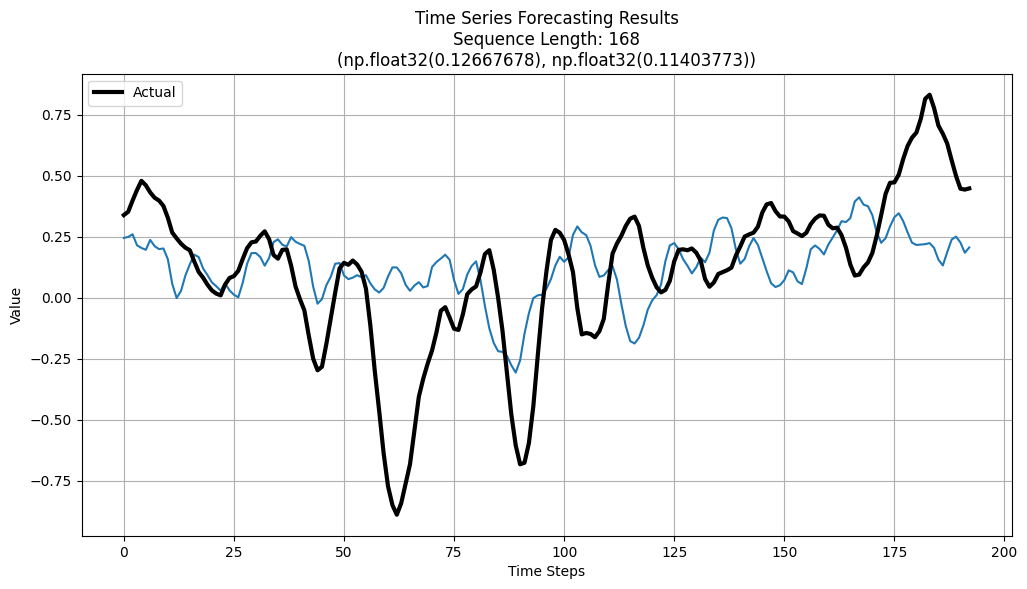

In [30]:

# Plot results
test_loss, predictions = evaluate(model, device, test_loader, criterion)
plot_predictions(data, predictions, seq_len)


# !!Old Stuff - do no use!!

# Embedded Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from src.embedded_model import TimeSeriesDataset, EmbeddedTransformerModel
from src.train import train_embedded
from src.plot import plot_predictions

In [ ]:
# Generate sample data
np.random.seed(42)
torch.manual_seed(42)

# Create synthetic dataset
time_steps = 1000
features = 1
categories = 10
t = np.linspace(0, 10 * np.pi, time_steps)  # Generate 1000 evenly spaced points over 10 periods
data = np.sin(t) + 0.01 * np.random.randn(len(t))  # Add noise (std dev = 0.1)
X = np.random.rand(time_steps, features)
for i in range(len(X)):
    X[i] = data[i]
y = data
cat_features = np.random.randint(0, categories, time_steps)


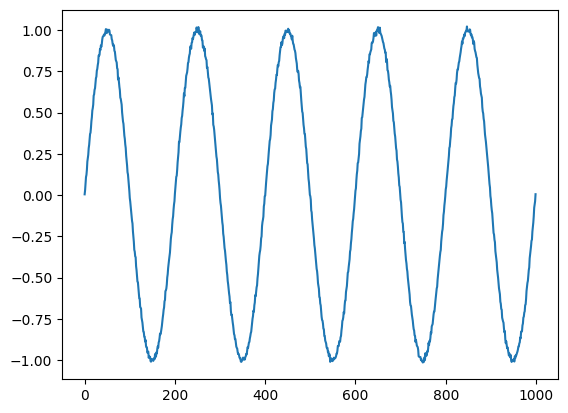

In [ ]:
plt.plot(X)